# Streaming History analysis

## 0. Import data and packages

In [92]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from PIL import Image
import requests
import random

pd.set_option('display.max_columns', None)

In [93]:
df = pd.read_csv(r'./data/streaming_data_clean_v2.csv')

In [94]:
df.head()

,Unnamed: 0,endTime,artistName,trackName,msPlayed,query,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,explicit,popularity,album_cover,genres
0,0,2019-12-28 18:17,Ghost,Cirice,113840,Cirice Ghost,0.555,0.798,3.0,-5.658,1.0,0.0279,0.002540,0.000015,0.1710,0.284,89.987,audio_features,3ZXZ9RMsznqgyHnyq0K5FL,spotify:track:3ZXZ9RMsznqgyHnyq0K5FL,https://api.spotify.com/v1/tracks/3ZXZ9RMsznqg...,https://api.spotify.com/v1/audio-analysis/3ZXZ...,362093.0,4.0,False,54.0,https://i.scdn.co/image/ab67616d0000b273a256ca...,"['hard rock', 'metal', 'rock']"
1,1,2019-12-29 12:57,Ghost,Year Zero,6976,Year Zero Ghost,0.469,0.705,7.0,-5.134,1.0,0.0458,0.030400,0.015500,0.6590,0.137,122.025,audio_features,1YBf7Tq9bpcVwvnlP8YbQS,spotify:track:1YBf7Tq9bpcVwvnlP8YbQS,https://api.spotify.com/v1/tracks/1YBf7Tq9bpcV...,https://api.spotify.com/v1/audio-analysis/1YBf...,350187.0,4.0,True,50.0,https://i.scdn.co/image/ab67616d0000b273cfcfd7...,"['hard rock', 'metal', 'rock']"
2,2,2019-12-29 12:58,Rise Against,Intro/Chamber The Cartridge,33215,Intro/Chamber T Rise Against,0.234,0.994,8.0,-4.037,1.0,0.3810,0.000340,0.000121,0.6730,0.194,164.397,audio_features,0aHUJdrNRAVrrdDyUwHYn6,spotify:track:0aHUJdrNRAVrrdDyUwHYn6,https://api.spotify.com/v1/tracks/0aHUJdrNRAVr...,https://api.spotify.com/v1/audio-analysis/0aHU...,214907.0,4.0,False,31.0,https://i.scdn.co/image/ab67616d0000b273eabc23...,"['chicago hardcore', 'chicago punk', 'hardcore..."
3,3,2019-12-29 12:58,Rise Against,Intro/Chamber The Cartridge,860,Intro/Chamber T Rise Against,0.234,0.994,8.0,-4.037,1.0,0.3810,0.000340,0.000121,0.6730,0.194,164.397,audio_features,0aHUJdrNRAVrrdDyUwHYn6,spotify:track:0aHUJdrNRAVrrdDyUwHYn6,https://api.spotify.com/v1/tracks/0aHUJdrNRAVr...,https://api.spotify.com/v1/audio-analysis/0aHU...,214907.0,4.0,False,31.0,https://i.scdn.co/image/ab67616d0000b273eabc23...,"['chicago hardcore', 'chicago punk', 'hardcore..."
4,4,2019-12-29 13:01,Rise Against,Injection,210846,Injection Rise Against,0.420,0.996,8.0,-2.961,0.0,0.0804,0.000229,0.000420,0.0897,0.433,105.686,audio_features,1wVUjggKup9hP2jd24gLSg,spotify:track:1wVUjggKup9hP2jd24gLSg,https://api.spotify.com/v1/tracks/1wVUjggKup9h...,https://api.spotify.com/v1/audio-analysis/1wVU...,199213.0,4.0,False,47.0,https://i.scdn.co/image/ab67616d0000b27390fef0...,"['chicago hardcore', 'chicago punk', 'hardcore..."


In [95]:
df.shape

(20406, 28)

## 1. Data Cleaning

### 1.1 Remove variables
Doing some removal of variables that don't provide any aditional insight

In [96]:
df.columns

Index(['Unnamed: 0', 'endTime', 'artistName', 'trackName', 'msPlayed', 'query',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature', 'explicit', 'popularity', 'album_cover', 'genres'],
      dtype='object')

In [97]:
vars_exclude = ['Unnamed: 0', 'uri', 'track_href', 'analysis_url', 'type', 'id'] # all of these variables provide information with weblinks to spotify for either analysis from Spotify
df['id_stream'] = np.arange(0, df.shape[0], 1) # make id more readable

vars_keep = [var for var in df.columns if var not in vars_exclude]

df_filtered = df[vars_keep]

print(f"We removed {df.shape[1] - df_filtered.shape[1]} variables")

We removed 6 variables


### 1.2 Missing values

In [98]:
df_filtered.isnull().sum()

endTime               0
artistName            0
trackName             0
msPlayed              0
query                 0
danceability        525
energy              525
key                 525
loudness            525
mode                525
speechiness         525
acousticness        525
instrumentalness    525
liveness            525
valence             525
tempo               525
duration_ms         525
time_signature      525
explicit            525
popularity          525
album_cover         525
genres              525
id_stream             0
dtype: int64

In [99]:
missing_stream_data = df_filtered['popularity'].isnull().sum()
print(f"We have {missing_stream_data} streams with missing features, which accounts for {(missing_stream_data / df_filtered.shape[0]):.2%} of the data")

We have 525 streams with missing features, which accounts for 2.57% of the data


In [100]:
df_clean = df_filtered.dropna().reset_index(drop = True)
df_clean.isnull().sum()

endTime             0
artistName          0
trackName           0
msPlayed            0
query               0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
explicit            0
popularity          0
album_cover         0
genres              0
id_stream           0
dtype: int64

### 1.3 Creating new features

In [101]:
df_clean['timeStamp'] = pd.to_datetime(df_clean.endTime)

In [102]:
df_clean['streamDate'] = df_clean.timeStamp.dt.date # for date
df_clean['streamTime'] = df_clean.timeStamp.dt.time # for time

df_clean['streamYear'] = df_clean.apply(lambda row: row.timeStamp.year, axis = 1) # for year
df_clean['streamMonth'] = df_clean.apply(lambda row: row.timeStamp.month, axis = 1) # for month
df_clean['streamDay'] = df_clean.apply(lambda row: row.timeStamp.day, axis = 1) # for day
df_clean['streamHour'] = df_clean.apply(lambda row: row.timeStamp.hour, axis = 1) # for hour
df_clean['streamWeekDay'] = df_clean.apply(lambda row: row.timeStamp.weekday(), axis = 1) # for hour

df_clean.drop(['endTime'], axis = 1, inplace = True) # We can drop this

In [103]:
df_clean.head()

,artistName,trackName,msPlayed,query,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,explicit,popularity,album_cover,genres,id_stream,timeStamp,streamDate,streamTime,streamYear,streamMonth,streamDay,streamHour,streamWeekDay
0,Ghost,Cirice,113840,Cirice Ghost,0.555,0.798,3.0,-5.658,1.0,0.0279,0.002540,0.000015,0.1710,0.284,89.987,362093.0,4.0,False,54.0,https://i.scdn.co/image/ab67616d0000b273a256ca...,"['hard rock', 'metal', 'rock']",0,2019-12-28 18:17:00,2019-12-28,18:17:00,2019,12,28,18,5
1,Ghost,Year Zero,6976,Year Zero Ghost,0.469,0.705,7.0,-5.134,1.0,0.0458,0.030400,0.015500,0.6590,0.137,122.025,350187.0,4.0,True,50.0,https://i.scdn.co/image/ab67616d0000b273cfcfd7...,"['hard rock', 'metal', 'rock']",1,2019-12-29 12:57:00,2019-12-29,12:57:00,2019,12,29,12,6
2,Rise Against,Intro/Chamber The Cartridge,33215,Intro/Chamber T Rise Against,0.234,0.994,8.0,-4.037,1.0,0.3810,0.000340,0.000121,0.6730,0.194,164.397,214907.0,4.0,False,31.0,https://i.scdn.co/image/ab67616d0000b273eabc23...,"['chicago hardcore', 'chicago punk', 'hardcore...",2,2019-12-29 12:58:00,2019-12-29,12:58:00,2019,12,29,12,6
3,Rise Against,Intro/Chamber The Cartridge,860,Intro/Chamber T Rise Against,0.234,0.994,8.0,-4.037,1.0,0.3810,0.000340,0.000121,0.6730,0.194,164.397,214907.0,4.0,False,31.0,https://i.scdn.co/image/ab67616d0000b273eabc23...,"['chicago hardcore', 'chicago punk', 'hardcore...",3,2019-12-29 12:58:00,2019-12-29,12:58:00,2019,12,29,12,6
4,Rise Against,Injection,210846,Injection Rise Against,0.420,0.996,8.0,-2.961,0.0,0.0804,0.000229,0.000420,0.0897,0.433,105.686,199213.0,4.0,False,47.0,https://i.scdn.co/image/ab67616d0000b27390fef0...,"['chicago hardcore', 'chicago punk', 'hardcore...",4,2019-12-29 13:01:00,2019-12-29,13:01:00,2019,12,29,13,6


In [104]:
col         = 'streamWeekDay'
conditions  = [ df_clean[col] == 0, df_clean[col] == 1, df_clean[col] == 2, df_clean[col] == 3, df_clean[col] == 4,
              df_clean[col] == 5, df_clean[col] == 6]
weekdays    = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    
df_clean["streamWeekDay_str"] = np.select(conditions, weekdays, default=np.nan)

### 1.4 Creating lists based on datatypes

In [105]:
df_clean.dtypes

artistName                   object
trackName                    object
msPlayed                      int64
query                        object
danceability                float64
energy                      float64
key                         float64
loudness                    float64
mode                        float64
speechiness                 float64
acousticness                float64
instrumentalness            float64
liveness                    float64
valence                     float64
tempo                       float64
duration_ms                 float64
time_signature              float64
explicit                     object
popularity                  float64
album_cover                  object
genres                       object
id_stream                     int32
timeStamp            datetime64[ns]
streamDate                   object
streamTime                   object
streamYear                    int64
streamMonth                   int64
streamDay                   

In [106]:
time = [var 
        for var in df_clean.columns 
        if var.startswith('stream') or df_clean[var].dtypes == 'datetime64[ns]']

discrete = [var 
            for var in df_clean.columns 
            if df_clean[var].dtypes != 'O' and df_clean[var].nunique() < 15 and var not in time]

continuous = [var 
              for var in df_clean.columns 
              if df_clean[var].dtypes != 'O' and var not in time and var not in discrete]

categorical = [var 
              for var in df_clean.columns 
              if df_clean[var].dtypes == 'O' and var not in time]

check = (len(discrete) + len(continuous) + len(time) + len(categorical) == len(df_clean.columns))

print(f"Check if all variables are assigned to a list: {check}")


Check if all variables are assigned to a list: True


## 2. Main statistics

Several features were extracted using the Spotify for Developers API. Taking from the documentation, here is the description of the features used here:

* **duration_ms** - The duration of the track in milliseconds.
* **key** - The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.
* **mode** - Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
* **time_signature** - 	An estimated overall time signature of a track.
* **acousticness** - A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
* **danceability** - Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
* **energy** - Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy.
* **instrumentalness** - Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context.
* **liveness** - Detects the presence of an audience in the recording.
* **loudness** - The overall loudness of a track in decibels (dB).
* **speechiness** - Speechiness detects the presence of spoken words in a track.
* **valence** - A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track.
* **tempo** - The overall estimated tempo of a track in beats per minute (BPM). 

In [107]:
df_clean.head()

,artistName,trackName,msPlayed,query,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,explicit,popularity,album_cover,genres,id_stream,timeStamp,streamDate,streamTime,streamYear,streamMonth,streamDay,streamHour,streamWeekDay,streamWeekDay_str
0,Ghost,Cirice,113840,Cirice Ghost,0.555,0.798,3.0,-5.658,1.0,0.0279,0.002540,0.000015,0.1710,0.284,89.987,362093.0,4.0,False,54.0,https://i.scdn.co/image/ab67616d0000b273a256ca...,"['hard rock', 'metal', 'rock']",0,2019-12-28 18:17:00,2019-12-28,18:17:00,2019,12,28,18,5,Saturday
1,Ghost,Year Zero,6976,Year Zero Ghost,0.469,0.705,7.0,-5.134,1.0,0.0458,0.030400,0.015500,0.6590,0.137,122.025,350187.0,4.0,True,50.0,https://i.scdn.co/image/ab67616d0000b273cfcfd7...,"['hard rock', 'metal', 'rock']",1,2019-12-29 12:57:00,2019-12-29,12:57:00,2019,12,29,12,6,Sunday
2,Rise Against,Intro/Chamber The Cartridge,33215,Intro/Chamber T Rise Against,0.234,0.994,8.0,-4.037,1.0,0.3810,0.000340,0.000121,0.6730,0.194,164.397,214907.0,4.0,False,31.0,https://i.scdn.co/image/ab67616d0000b273eabc23...,"['chicago hardcore', 'chicago punk', 'hardcore...",2,2019-12-29 12:58:00,2019-12-29,12:58:00,2019,12,29,12,6,Sunday
3,Rise Against,Intro/Chamber The Cartridge,860,Intro/Chamber T Rise Against,0.234,0.994,8.0,-4.037,1.0,0.3810,0.000340,0.000121,0.6730,0.194,164.397,214907.0,4.0,False,31.0,https://i.scdn.co/image/ab67616d0000b273eabc23...,"['chicago hardcore', 'chicago punk', 'hardcore...",3,2019-12-29 12:58:00,2019-12-29,12:58:00,2019,12,29,12,6,Sunday
4,Rise Against,Injection,210846,Injection Rise Against,0.420,0.996,8.0,-2.961,0.0,0.0804,0.000229,0.000420,0.0897,0.433,105.686,199213.0,4.0,False,47.0,https://i.scdn.co/image/ab67616d0000b27390fef0...,"['chicago hardcore', 'chicago punk', 'hardcore...",4,2019-12-29 13:01:00,2019-12-29,13:01:00,2019,12,29,13,6,Sunday


In [108]:
unique_songs = df_clean['trackName'].unique()
total_streams = df_clean['trackName'].count()

print(f" We have a total of {len(unique_songs)} unique songs which account for {(len(unique_songs) / total_streams):.2%} of total streams")

 We have a total of 5168 unique songs which account for 25.99% of total streams


In [109]:
unique_artists = df_clean['artistName'].unique()
print(f"We have a total of {len(unique_artists)} artists in the stream history")

We have a total of 1652 artists in the stream history


In [110]:
df_clean.describe()

,msPlayed,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,popularity,id_stream,streamYear,streamMonth,streamDay,streamHour,streamWeekDay
count,1.988100e+04,19881.000000,19881.000000,19881.000000,19881.000000,19881.000000,19881.000000,19881.000000,19881.000000,19881.000000,19881.000000,19881.000000,1.988100e+04,19881.000000,19881.000000,19881.000000,19881.000000,19881.000000,19881.000000,19881.000000,19881.000000
mean,1.247024e+05,0.452419,0.732765,5.292842,-7.408073,0.569539,0.064331,0.148945,0.161671,0.208439,0.379386,125.329674,2.607102e+05,3.878477,45.626125,10168.127106,2019.992053,6.282632,15.801016,15.830542,2.971832
std,1.350463e+05,0.142701,0.262670,3.561483,5.200422,0.495153,0.050644,0.289739,0.301358,0.175014,0.219322,29.888260,9.586171e+04,0.417090,16.608663,5894.825726,0.088795,3.578067,8.902639,5.247775,2.005629
min,0.000000e+00,0.000000,0.000429,0.000000,-41.284000,0.000000,0.000000,0.000001,0.000000,0.018000,0.000000,0.000000,1.148000e+04,0.000000,0.000000,0.000000,2019.000000,1.000000,1.000000,0.000000,0.000000
25%,1.599000e+03,0.356000,0.605000,2.000000,-8.396000,0.000000,0.035700,0.000226,0.000018,0.098300,0.211000,101.580000,2.071200e+05,4.000000,34.000000,5074.000000,2020.000000,3.000000,8.000000,11.000000,1.000000
50%,8.280000e+04,0.460000,0.838000,5.000000,-5.802000,1.000000,0.048300,0.003420,0.001720,0.135000,0.345000,125.017000,2.473730e+05,4.000000,46.000000,10138.000000,2020.000000,6.000000,15.000000,17.000000,3.000000
75%,2.299400e+05,0.541000,0.933000,8.000000,-4.429000,1.000000,0.072800,0.090100,0.122000,0.284000,0.524000,145.085000,2.994400e+05,4.000000,57.000000,15272.000000,2020.000000,9.000000,24.000000,20.000000,5.000000
max,1.440939e+06,0.971000,0.998000,11.000000,-0.140000,1.000000,0.879000,0.996000,0.992000,0.996000,0.989000,219.701000,2.188974e+06,5.000000,94.000000,20405.000000,2020.000000,12.000000,31.000000,23.000000,6.000000


In [111]:
def get_top_artists(df, n_artists: int = 5):
    '''
    funtion to get top n artists with the most streams from streaming database
    -------------------------------------------------------
    arguments:
        df = df of streaming database
        n_tracks = number of top tracks to get
    '''
    df = df.copy()
    top_artists = df.groupby(['artistName'])['id_stream'].count().sort_values(ascending = False).iloc[:n_artists]
    
    return top_artists

In [112]:
get_top_artists(df_clean, n_artists = 5)

artistName
Ghost           1865
Anathema        1056
Moonspell        932
Trivium          775
Rise Against     683
Name: id_stream, dtype: int64

In [113]:
def print_top_tracks(df, n_tracks: int):
    '''
    funtion to print top n tracks from streaming database
    -------------------------------------------------------
    arguments:
        df = df of streaming database
        n_tracks = number of top tracks to get
    '''
    df = df.copy()
    top_tracks = df.groupby('trackName')['id_stream'].count().sort_values(ascending = False)[:n_tracks,]

    for i, song in enumerate(list((top_tracks).index)):
        stream = df.loc[df['trackName'] == song]
        artist = stream['artistName'].iloc[0]

        print(f"The #{i+1} streamed song '{song}' is from '{artist}', with a total of {top_tracks.iloc[i]} streams")

In [114]:
print_top_tracks(df_clean, n_tracks = 10)

The #1 streamed song 'Untouchable Part 2' is from 'Anathema', with a total of 104 streams
The #2 streamed song 'Untouchable Part 1' is from 'Anathema', with a total of 101 streams
The #3 streamed song 'Mary On A Cross' is from 'Ghost', with a total of 95 streams
The #4 streamed song 'Dance Macabre' is from 'Ghost', with a total of 93 streams
The #5 streamed song 'Cirice' is from 'Ghost', with a total of 85 streams
The #6 streamed song 'Faith' is from 'Ghost', with a total of 82 streams
The #7 streamed song 'Thin Air' is from 'Anathema', with a total of 80 streams
The #8 streamed song 'Rats' is from 'Ghost', with a total of 74 streams
The #9 streamed song 'Fear' is from 'CommonWealth', with a total of 72 streams
The #10 streamed song 'Everything' is from 'Anathema', with a total of 72 streams


This is regarding the number of streams though. What about in terms of actual played time?

In [115]:
def print_top_most_played(df, n_tracks: int):
    '''
    funtion to print top n most played tracks from streaming database
    -------------------------------------------------------
    arguments:
        df = df of streaming database
        n_tracks = number of top tracks to get
    '''
    df = df.copy()
    top_tracks = df.groupby('trackName')['msPlayed'].sum().sort_values(ascending = False)[:n_tracks,]

    for i, song in enumerate(list((top_tracks).index)):
        stream = df.loc[df['trackName'] == song]
        artist = stream['artistName'].iloc[0]
        total_minutes = float(top_tracks.iloc[i]/60)
        
        print(f"The #{i+1} most played song '{song}' is from '{artist}', with a total of {total_minutes:.0f} minutes it corresponds to approx {total_minutes / 60 / 24:.0f} days")

In [116]:
print_top_most_played(df_clean, n_tracks=5)

The #1 most played song 'Untouchable Part 1' is from 'Anathema', with a total of 483239 minutes it corresponds to approx 336 days
The #2 most played song 'Cirice' is from 'Ghost', with a total of 357669 minutes it corresponds to approx 248 days
The #3 most played song 'Untouchable Part 2' is from 'Anathema', with a total of 350230 minutes it corresponds to approx 243 days
The #4 most played song 'A Simple Mistake' is from 'Anathema', with a total of 349046 minutes it corresponds to approx 242 days
The #5 most played song 'Thin Air' is from 'Anathema', with a total of 330481 minutes it corresponds to approx 230 days


## 3. Visualizations

### 3.1 Categorical variables

In [117]:
categorical

['artistName', 'trackName', 'query', 'explicit', 'album_cover', 'genres']

In [118]:
for var in categorical:
    print(f"{var} has {df_clean[var].nunique()} unique values")

artistName has 1652 unique values
trackName has 5168 unique values
query has 5239 unique values
explicit has 2 unique values
album_cover has 2716 unique values
genres has 1180 unique values


Categorical variables have a really high cardinality. Let's just show the top 20 in visualizations

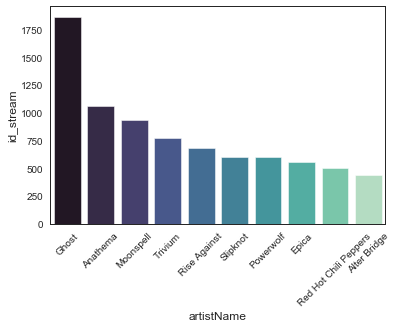

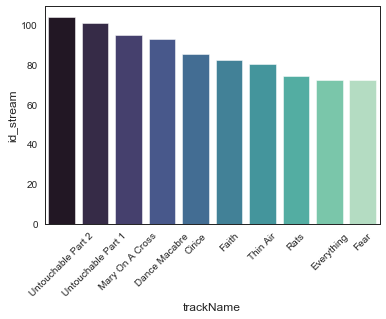

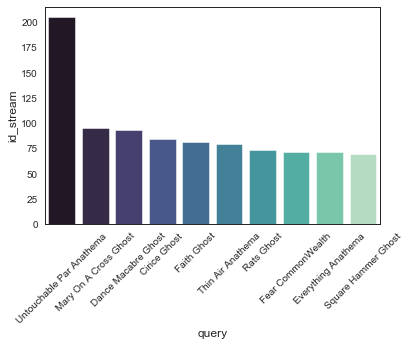

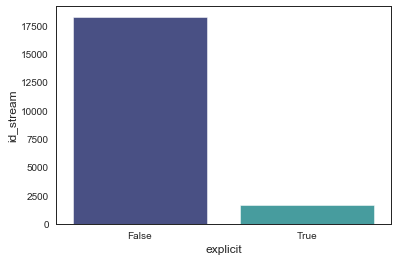

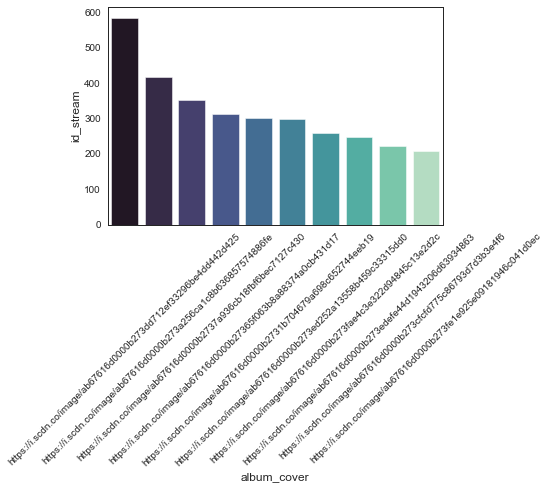

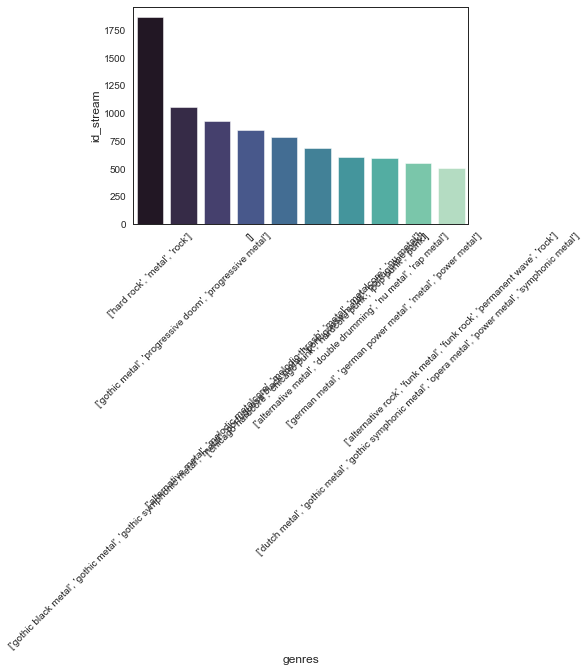

In [119]:
plt.style.use('ggplot')
sns.set_style('white')
for var in categorical:
    df = df_clean.copy()
    
    fig, ax = plt.subplots()
    if df[var].nunique() > 20:
            
        group = df.groupby(var, as_index = False)['id_stream'].count()
        top_10 = group.sort_values(by = 'id_stream', ascending = False)[:10].reset_index(drop = True)
        
        ax = sns.barplot(x = var, y = 'id_stream', data = top_10, palette = 'mako')
        ax.set_xticklabels(top_10[var], rotation = 45)
    else:
        group = df.groupby(var, as_index = False)['id_stream'].count()
        count = group.sort_values(by = 'id_stream', ascending = False)
        sns.barplot(x = var, y = 'id_stream', data = count, palette = 'mako')

In [142]:
def print_album_cover(df: pd.DataFrame, artist: str):
    
    df_ = df.copy()
    
    artist = artist

    df_filter = df_.loc[df_clean['artistName'] == artist]
    
    # get url and open image
    url = random.choice(df_filter['album_cover'].values)
    im = Image.open(requests.get(url, stream=True).raw)
    
    return im

In [208]:
pd.DataFrame(df_clean.groupby('artistName')['id_stream'].count().sort_values(ascending = False)).to_csv('artists.csv')

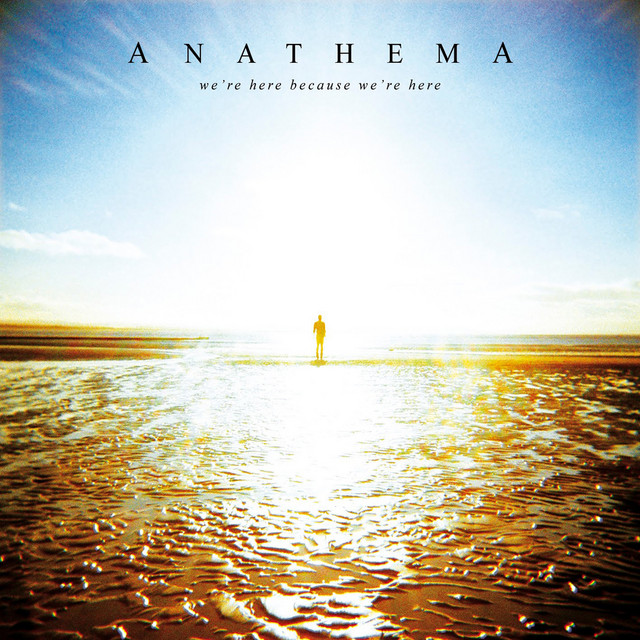

In [358]:
print_album_cover(df=df_clean, artist='Anathema')

### 3.2 Time variables

In [31]:
time

['timeStamp',
 'streamDate',
 'streamTime',
 'streamYear',
 'streamMonth',
 'streamDay',
 'streamHour',
 'streamWeekDay',
 'streamWeekDay_str']

In [32]:
time_series_features = pd.DataFrame(df_clean.groupby('streamDate').agg({'id_stream':['count'],
                                                                        'valence': ['mean'],
                                                                        'popularity': ['mean']}).reset_index())
time_series_features['streamDate'] = pd.to_datetime(time_series_features.streamDate)
time_series_features.set_index('streamDate', inplace = True)

time_series_2020 = time_series_features['01-01-2020':'31-12-2020']

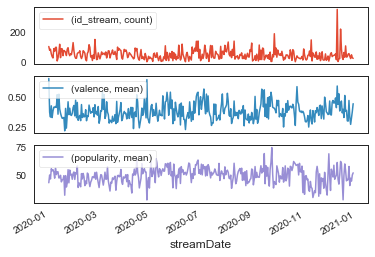

In [33]:
time_series_2020.plot(subplots = True)
plt.show()

In [64]:
january_streams = time_series_features['01-01-2020':'31-01-2020']

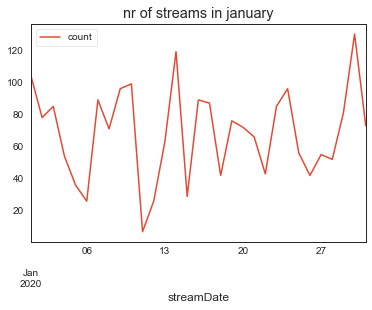

In [65]:
january_streams.id_stream.plot(title = 'nr of streams in january')

<Figure size 2160x720 with 0 Axes>

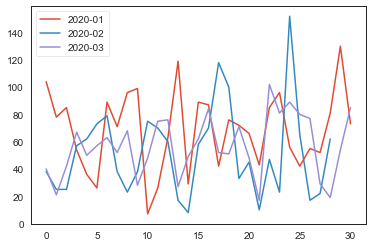

In [68]:
# dummy dataframe
counts = pd.DataFrame()

# Select data for each month and concatenate with counts 
for month in ['2020-01', '2020-02', '2020-03',
             # '2020-04', '2020-05', '2020-06',
             # '2020-07', '2020-08', '2020-09', 
             # '2020-10', '2020-11', '2020-12'
             ]:
    counts_per_year = time_series_2020.loc[month, [('id_stream', 'count')]].reset_index(drop=True)
    counts_per_year.columns = ['counts']
    counts_per_year.rename(columns={"counts": month}, inplace=True)
    counts = pd.concat([counts, counts_per_year], axis=1)
    
    #print(counts_per_year)
    
# Plot prices
plt.figure(figsize=(30,10))
counts.plot()
plt.show()

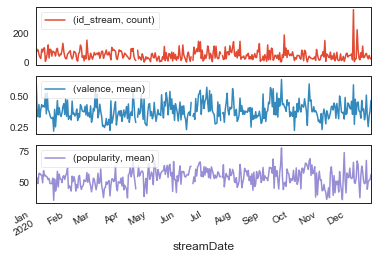

In [69]:
all_days = time_series_2020.asfreq('D')

all_days.plot(subplots = True)
plt.show()

### creating lag variables

In [70]:
all_days.columns

MultiIndex([( 'id_stream', 'count'),
            (   'valence',  'mean'),
            ('popularity',  'mean')],
           )

In [38]:
all_days['lagged'] = all_days[('id_stream', 'count')].shift(periods = -1)

In [43]:
all_days['shifted_5'] = all_days[('id_stream', 'count')].shift(periods=5)

In [57]:
all_days['change_30'] = all_days[('id_stream', 'count')] - all_days['shifted_30']
all_days['change_5'] =  all_days[('id_stream', 'count')] - all_days['shifted_5']
all_days['diff_5'] = all_days[('id_stream', 'count')].diff(periods = 5)

all_days['daily_perc_change'] = all_days[('id_stream', 'count')].pct_change(periods = 1)*100
all_days['weekly_perc_change'] = all_days[('id_stream', 'count')].pct_change(periods = 7)*100
all_days['monthly_perc_change'] = all_days[('id_stream', 'count')].pct_change(periods = 30)*100

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000256BE33DA08>,
      dtype=object)

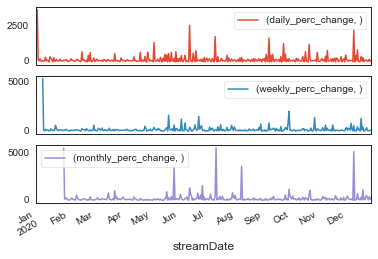

In [59]:
all_days[['daily_perc_change', 'weekly_perc_change', 'monthly_perc_change']].plot(subplots = True)

In [71]:
all_days.head()

,id_stream,valence,popularity
,count,mean,mean
streamDate,,,
2020-01-01,104.0,0.639970,48.567308
2020-01-02,78.0,0.374881,53.448718
2020-01-03,85.0,0.334665,48.741176
2020-01-04,54.0,0.433359,57.111111
2020-01-05,36.0,0.330958,57.111111


In [83]:
first_streams = all_days.iloc[0]

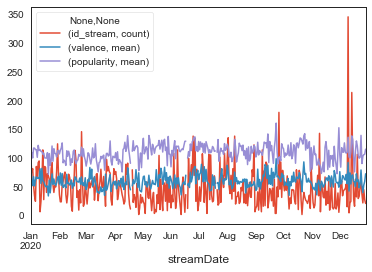

In [85]:
normalized = all_days.div(first_streams).mul(100)

normalized.plot()
plt.show()

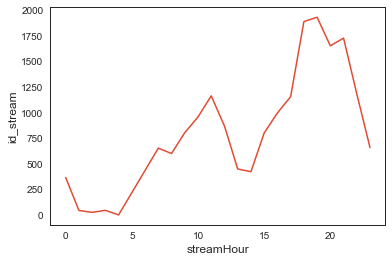

In [84]:
plot = df_clean.groupby('streamHour')['id_stream'].count().reset_index(drop = False)

ax = sns.lineplot(data = plot, x = 'streamHour', y = 'id_stream')

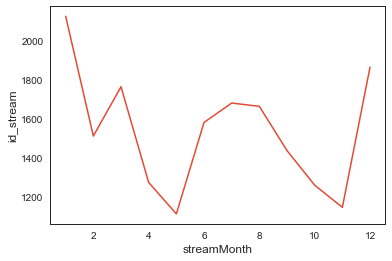

In [166]:
# Stream by month
plot = df_clean.groupby('streamMonth')['id_stream'].count().reset_index(drop = False)

ax = sns.lineplot(data = plot, x = 'streamMonth', y = 'id_stream')

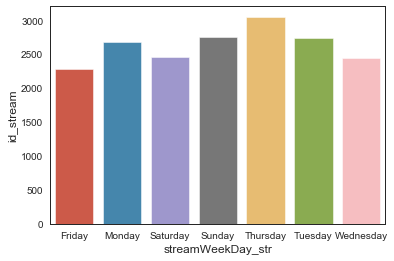

In [87]:
# Stream by weekday
plot = df_clean.groupby('streamWeekDay_str')['id_stream'].count().reset_index(drop = False)

ax = sns.barplot(data = plot, x = 'streamWeekDay_str', y = 'id_stream')

In [173]:
df_count_date = df_clean.groupby('streamDate')['id_stream'].count().reset_index()
df_count_date

,streamDate,id_stream
0,2019-12-28,1
1,2019-12-29,37
2,2019-12-30,59
3,2019-12-31,47
4,2020-01-01,104
...,...,...
360,2020-12-25,39
361,2020-12-26,23
362,2020-12-27,47
363,2020-12-28,29


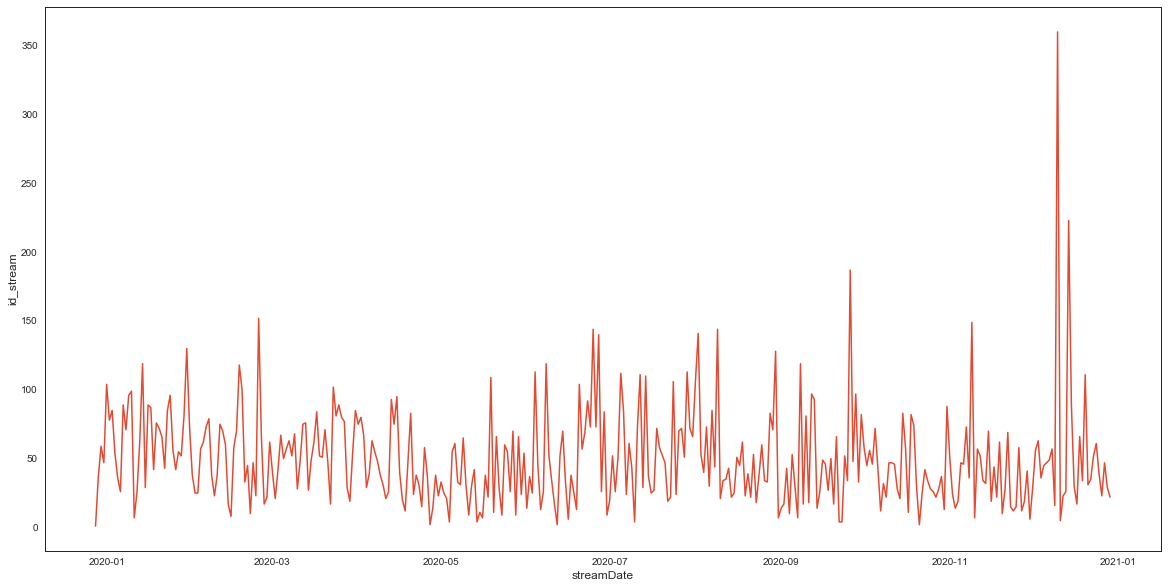

In [178]:
fig = plt.figure(figsize = (20,10))
sns.lineplot(data = df_count_date,x = 'streamDate', y = 'id_stream')

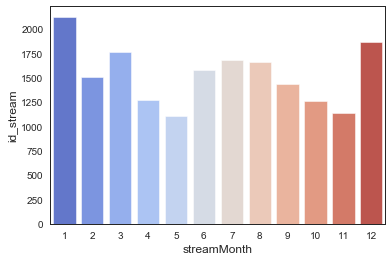

In [198]:
plot_month = df_clean.groupby('streamMonth')['id_stream'].count().reset_index()

sns.barplot(data = plot_month,x = 'streamMonth', y = 'id_stream', palette = 'coolwarm')

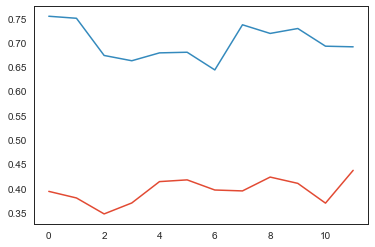

In [199]:
plot_month = df_clean.groupby(['streamMonth'])['valence', 'energy'].mean().reset_index()
plot_month

plt.plot(plot_month['valence'])
plt.plot(plot_month['energy'])